In [1]:
from biofuzznet.utils import read_sif
from biofuzznet.biofuzznet import BioFuzzNet
import networkx as nx
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

/Users/adr/miniconda3/envs/biofuzznet/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
nodes1, edges1 = read_sif("/Users/adr/Box/CAR_Tcells/Data/DREAMdata/prior_knowledge.sif")

In [3]:
nodes, edges = read_sif("/Users/adr/Box/CAR_Tcells/Data/DREAMdata/DREAM_PKN_for_BFZ_input.sif")
edges[("JNK", "p53")] = 1
sel_nodes = ["MKK4", "JNK", "p53", "RB"]

sel_edges = {k: v for k,v in edges.items() if (k[1] in sel_nodes) and (k[0] in sel_nodes)}
sel_edges

{('p53', 'RB'): '1', ('MKK4', 'JNK'): '1', ('JNK', 'p53'): 1}

In [4]:
G=nx.from_edgelist(sel_edges)

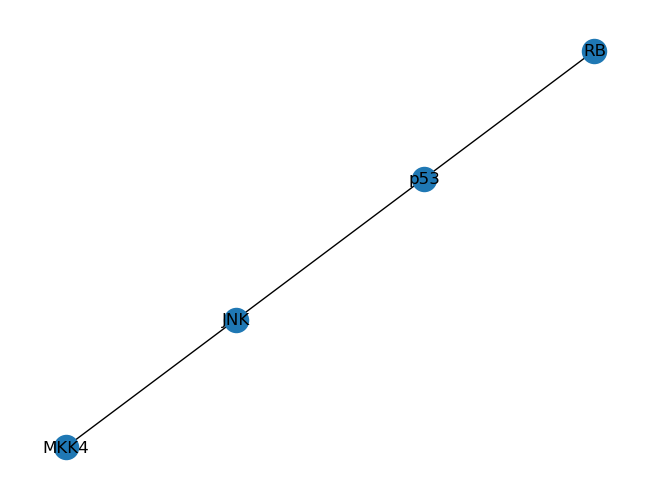

In [5]:
nx.draw(G, with_labels=True)

In [6]:
# Create an empty BioFuzzNet
my_model = BioFuzzNet(None, None)

# Add nodes
# my_model.add_fuzzy_node("input", "BIO")
my_model.add_fuzzy_node("p.MKK4", "BIO") # A biological node
my_model.add_fuzzy_node("p.JNK", 'BIO')
my_model.add_fuzzy_node("p.p53", "BIO")
my_model.add_fuzzy_node("p.RB", "BIO")
# Add edges
# my_model.add_transfer_edge("input","p.MKK4")
my_model.add_transfer_edge("p.MKK4","p.JNK") 
my_model.add_transfer_edge("p.JNK", "p.p53")
my_model.add_transfer_edge("p.p53", "p.RB")

In [7]:
my_model.root_nodes

['p.MKK4']

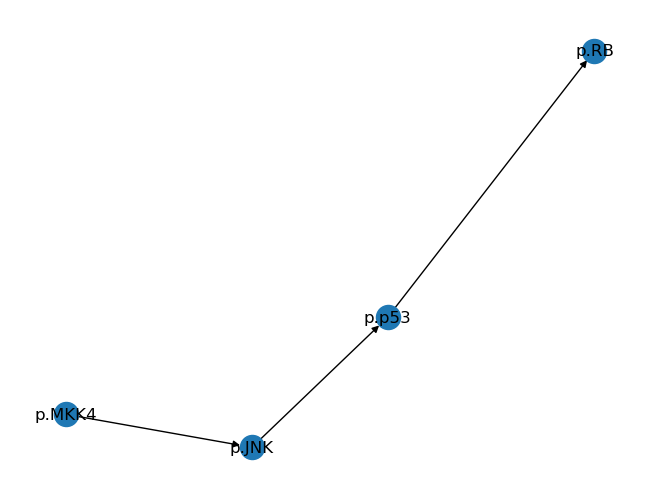

In [8]:
nx.draw(my_model, with_labels=True)

In [9]:
# It is initialised with random transfer function parameters
for edge in my_model.transfer_edges:
    # Each transfer edge has a layer
    layer = my_model.edges()[edge]["layer"]
    # Each layer has a n and an K parameter
    print(f"The edge {edge} has parameter n = {torch.exp(layer.n)} and K = {torch.sigmoid(layer.K)}")
    # Those parameters are torch.nn.Parameters and thus have a grad_fn which corresponds to their gradient


The edge ('p.MKK4', 'p.JNK') has parameter n = tensor([1.3392], grad_fn=<ExpBackward0>) and K = tensor([0.4069], grad_fn=<SigmoidBackward0>)
The edge ('p.JNK', 'p.p53') has parameter n = tensor([1.6258], grad_fn=<ExpBackward0>) and K = tensor([0.4572], grad_fn=<SigmoidBackward0>)
The edge ('p.p53', 'p.RB') has parameter n = tensor([0.6001], grad_fn=<ExpBackward0>) and K = tensor([0.1763], grad_fn=<SigmoidBackward0>)


In [10]:
cl_data = pd.read_csv("/Users/adr/Box/CAR_Tcells/Data/DREAMdata/MDAMB415.csv")

In [11]:
sel_data = cl_data.loc[(cl_data["time"]==9)&(cl_data["treatment"]=="EGF"),:][["p.p53", "p.MKK4", "p.JNK", "p.RB"]]
sel_data.reset_index(drop=True, inplace=True)
sel_data

,p.p53,p.MKK4,p.JNK,p.RB
0,2.425215,3.80494,1.904157,3.31361
1,2.371839,3.77449,1.161803,3.31460
2,2.524220,3.99033,3.139356,4.33987
3,1.480167,1.68518,0.841726,7.49475
4,1.956680,2.44052,0.688867,2.20794
...,...,...,...,...
16115,1.887030,2.23562,0.744003,2.76099
16116,3.374490,3.37031,1.053261,3.15090
16117,3.074775,4.12966,2.205374,2.92453
16118,1.865688,2.87943,0.688867,3.39494


In [12]:
train, test = train_test_split(sel_data)
print(train.shape)
print(test.shape)
train = train.to_dict("list")
test = test.to_dict("list")

train = {k: torch.DoubleTensor(v) for k, v in train.items()}
test = {k: torch.DoubleTensor(v) for k, v in test.items()}

input_train = {"p.MKK4" : train["p.MKK4"]}
input_test = {"p.MKK4": test["p.MKK4"]}


(12090, 4)
(4030, 4)


In [13]:
# Now we just need to specify some optimisation parameters

learning_rate = 5e-3
epochs = 20 # That seems like a lot, but 1 epoch is basically one simulation of the network on all datapoints, so we need a lot of them
batch_size = 300 

In [14]:
loss = my_model.conduct_optimisation(input = input_train,
                                     test_input = input_test,
                                     ground_truth=train,
                                     epochs = epochs, 
                                     test_ground_truth=test,
                                     learning_rate= learning_rate,
                                     batch_size= batch_size
                                         )

There were no root nodes, ['p.MKK4'] were used as input


100%|█████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.85it/s]


In [15]:
loss

,time,loss,phase
0,2023-03-13 10:50:44.709208,5.150943,train
1,2023-03-13 10:50:44.725333,4.797187,train
2,2023-03-13 10:50:44.740552,4.758126,train
3,2023-03-13 10:50:44.754152,5.215191,train
4,2023-03-13 10:50:44.767718,4.521864,train
...,...,...,...
835,2023-03-13 10:50:55.458838,3.862866,train
836,2023-03-13 10:50:55.471981,3.657105,train
837,2023-03-13 10:50:55.484301,3.517208,train
838,2023-03-13 10:50:55.494894,4.382876,train


<AxesSubplot: xlabel='time', ylabel='loss'>

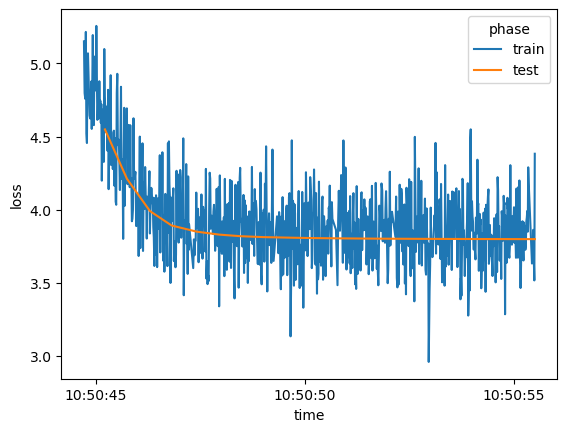

In [16]:
sns.lineplot(data=loss, x='time', y='loss', hue='phase')

# Leave a treatment out

In [17]:
all_treatments = ['EGF', 'full', 'iEGFR', 'iMEK', 'iPI3K', 'iPKC']
test_treatments = ['iEGFR']
train_treatments = [treatment for treatment in all_treatments if not treatment in test_treatments]

train = cl_data.loc[(cl_data["time"]==9)&(cl_data["treatment"].isin(train_treatments)), ["p.p53", "p.MKK4", "p.JNK", "p.RB"]]
test = cl_data.loc[(cl_data["time"]==9)&(cl_data["treatment"].isin(test_treatments)), ["p.p53", "p.MKK4", "p.JNK", "p.RB"]]
n_test = len(test)

print(train.shape)
print(test.shape)
train = train.to_dict("list")
test = test.to_dict("list")

train = {k: torch.DoubleTensor(v) for k, v in train.items()}
test = {k: torch.DoubleTensor(v) for k, v in test.items()}

input_train = {"p.MKK4" : train["p.MKK4"]}
input_test = {"p.MKK4": test["p.MKK4"]}

(41061, 4)
(11705, 4)


In [18]:
# Create an empty BioFuzzNet
my_model = BioFuzzNet(None, None)

# Add nodes
# my_model.add_fuzzy_node("input", "BIO")
my_model.add_fuzzy_node("p.MKK4", "BIO") # A biological node
my_model.add_fuzzy_node("p.JNK", 'BIO')
my_model.add_fuzzy_node("p.p53", "BIO")
my_model.add_fuzzy_node("p.RB", "BIO")
# Add edges
# my_model.add_transfer_edge("input","p.MKK4")
my_model.add_transfer_edge("p.MKK4","p.JNK") 
my_model.add_transfer_edge("p.JNK", "p.p53")
my_model.add_transfer_edge("p.p53", "p.RB")

In [19]:
# Now we just need to specify some optimisation parameters

learning_rate = 5e-3
epochs = 20 # That seems like a lot, but 1 epoch is basically one simulation of the network on all datapoints, so we need a lot of them
batch_size = 300 

In [20]:
loss = my_model.conduct_optimisation(input = input_train,
                                     test_input = input_test,
                                     ground_truth=train,
                                     epochs = epochs, 
                                     test_ground_truth=test,
                                     learning_rate= learning_rate,
                                     batch_size= batch_size
                                         )

There were no root nodes, ['p.MKK4'] were used as input


100%|█████████████████████████████████████████████████████████████| 20/20 [00:36<00:00,  1.83s/it]


In [21]:
# Create an empty BioFuzzNet
random_model = BioFuzzNet(None, None)

# Add nodes
# my_model.add_fuzzy_node("input", "BIO")
random_model.add_fuzzy_node("p.MKK4", "BIO") # A biological node
random_model.add_fuzzy_node("p.JNK", 'BIO')
random_model.add_fuzzy_node("p.p53", "BIO")
random_model.add_fuzzy_node("p.RB", "BIO")
# Add edges
# my_model.add_transfer_edge("input","p.MKK4")
random_model.add_transfer_edge("p.MKK4","p.JNK") 
random_model.add_transfer_edge("p.JNK", "p.p53")
random_model.add_transfer_edge("p.p53", "p.RB")

random_model.initialise_random_truth_and_output(n_test)

random_pred = random_model.output_states
random_pred["p.MKK4"] = test["p.MKK4"]

loss_func = torch.nn.MSELoss()
MSE = sum([loss_func(test[node], random_pred[node]).item() for node in my_model.nodes]) / len(my_model.nodes)
print(MSE)

4.980062105218941


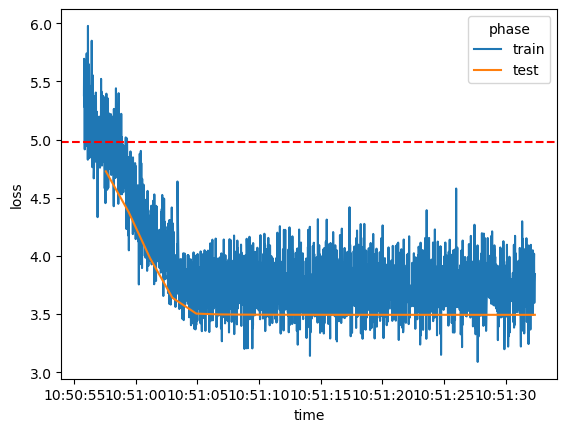

In [22]:
sns.lineplot(data=loss, x='time', y='loss', hue='phase')
plt.axhline(y=MSE, color="red", linestyle = "--")

In [23]:
random_model.output_states["p.MKK4"].size()

torch.Size([11705])

In [24]:
my_model.nodes

NodeView(('p.MKK4', 'p.JNK', 'p.p53', 'p.RB'))

# Fixed intermediate node

In [25]:
# Create an empty BioFuzzNet
my_model = BioFuzzNet(None, None)

# Add nodes
my_model.add_fuzzy_node("input", "BIO")
my_model.add_fuzzy_node("p.MEK", "BIO") # A biological node
my_model.add_fuzzy_node("p.ERK", 'BIO')
my_model.add_fuzzy_node("p.p90RSK", "BIO")
my_model.add_fuzzy_node("p.CREB", "BIO")
# Add edges
my_model.add_transfer_edge("input","p.MEK")
my_model.add_transfer_edge("p.MEK","p.ERK") 
my_model.add_transfer_edge("p.ERK", "p.p90RSK")
my_model.add_transfer_edge("p.p90RSK", "p.CREB")

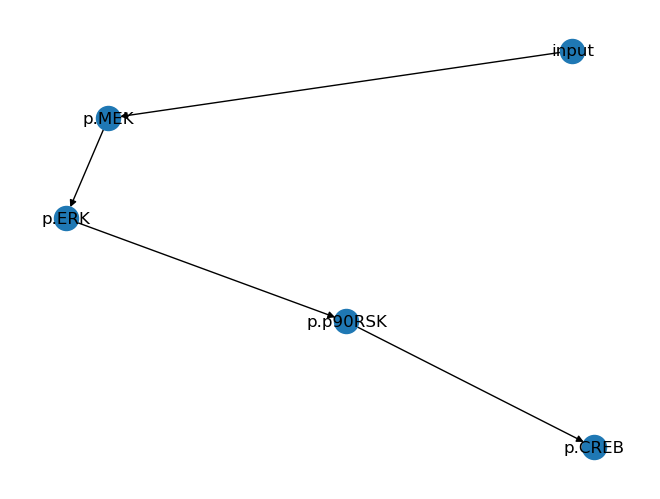

In [26]:
nx.draw(my_model, with_labels=True)

In [31]:
sel_data = cl_data.loc[(cl_data["time"]==9)&(cl_data["treatment"]=="EGF"),:][['p.MEK', 'p.ERK', 'p.p90RSK', 'p.CREB']]
sel_data.reset_index(drop=True, inplace=True)
sel_data["input"] = 1.
sel_data

,p.MEK,p.ERK,p.p90RSK,p.CREB,input
0,2.543680,2.610784,4.87339,0.823494,1.0
1,2.662760,2.033088,4.54221,1.635813,1.0
2,2.092250,1.636591,3.03340,1.456649,1.0
3,0.596945,0.738522,3.20476,0.769913,1.0
4,1.434150,1.619133,3.24160,0.354778,1.0
...,...,...,...,...,...
16115,1.859420,1.403369,1.60703,0.943596,1.0
16116,2.879670,2.758476,3.74693,1.878022,1.0
16117,3.058100,2.435951,4.08282,2.325291,1.0
16118,2.876960,1.793564,3.67985,0.342839,1.0


In [38]:
train, test = train_test_split(sel_data)
print(train.shape)
print(test.shape)
train = train.to_dict("list")
test = test.to_dict("list")

train = {k: torch.DoubleTensor(v) for k, v in train.items()}
test = {k: torch.DoubleTensor(v) for k, v in test.items()}

input_train = {"input": train["input"], "p.MEK" : train["p.MEK"]}
input_test = {"input": test["input"],"p.MEK": test["p.MEK"]}


(12090, 5)
(4030, 5)


In [39]:
# Now we just need to specify some optimisation parameters

learning_rate = 5e-3
epochs = 20 # That seems like a lot, but 1 epoch is basically one simulation of the network on all datapoints, so we need a lot of them
batch_size = 300 

In [40]:
loss = my_model.conduct_optimisation(input = input_train,
                                     test_input = input_test,
                                     ground_truth=train,
                                     epochs = epochs, 
                                     test_ground_truth=test,
                                     learning_rate= learning_rate,
                                     batch_size= batch_size
                                         )

There were no root nodes, ['input', 'p.MEK'] were used as input


  0%|                                                                      | 0/20 [00:00<?, ?it/s]/Users/adr/miniconda3/envs/biofuzznet/lib/python3.10/site-packages/torch/autograd/__init__.py:173: UserWarning: Error detected in MseLossBackward0. Traceback of forward call that caused the error:
  File "/Users/adr/miniconda3/envs/biofuzznet/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/adr/miniconda3/envs/biofuzznet/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/adr/miniconda3/envs/biofuzznet/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/adr/miniconda3/envs/biofuzznet/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  File "/Users/adr/miniconda3/envs/biofuzznet/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
    sel

RuntimeError: Function 'MseLossBackward0' returned nan values in its 0th output.